# Optimization TL;DR:

What was killing us was the `dask.array.rechunk` because it was splitting the data into separate blocks.
By not calling `rechunk` it keeps more of the data in a single chunk and thus faster reads.
It also looks like `optimize` is called internally during `dask.array.__getitem__` because `optimize` has little
to no effect on the retrieval times. It actually states this on their doc about slicing [here](https://docs.dask.org/en/latest/array-slicing.html#efficiency).

But this leaves the open question.... why is it choosing chunks the way it is for our data.
I feel like it _should_ be choosing chunks of (1, 1, 1, 1, Y, X) for example.

Maybe these are bad examples because they are random data but worth running this notebook on real data I guess.

### Results
| test                                                	| single plane read time 	| optimized single plane read time 	|
|-----------------------------------------------------	|------------------------	|----------------------------------	|
| raw -> rechunk -> optimize (current implementation) 	| 1.79 s ± 27.4 ms       	| 1.68 s ± 12.7 ms                 	|
| raw -> optimize                                     	| 743 ms ± 6.11 ms       	| 733 ms ± 7.81 ms                 	|
| raw                                                 	| 743 ms ± 15.9 ms       	| 745 ms ± 9.27 ms                 	|

Adding `rechunk` to the calls more than doubles the time per slice read. My assumption would be that on real data this will be even worse which is why we saw attrocious read times today.

In [1]:
from dask.array.random import random
from dask import optimize

### Rechunk + Optimize

In [2]:
img = random((6, 100, 4, 75, 200, 200))
img = img.rechunk((1, 1, 1, 1, 200, 200))
img = optimize(img)[0]
img

,Array,Chunk
Bytes,57.60 GB,320.00 kB
Shape,"(6, 100, 4, 75, 200, 200)","(1, 1, 1, 1, 200, 200)"
Count,440192 Tasks,180000 Chunks
Type,float64,numpy.ndarray


In [3]:
not_opt_plane = img[0, 0, 0, 0, :]
not_opt_plane

dask.array<getitem, shape=(200, 200), dtype=float64, chunksize=(200, 200), chunktype=numpy.ndarray>

In [4]:
opt_plane = optimize(img[0, 0, 0, 0, :])[0]
opt_plane

dask.array<getitem, shape=(200, 200), dtype=float64, chunksize=(200, 200), chunktype=numpy.ndarray>

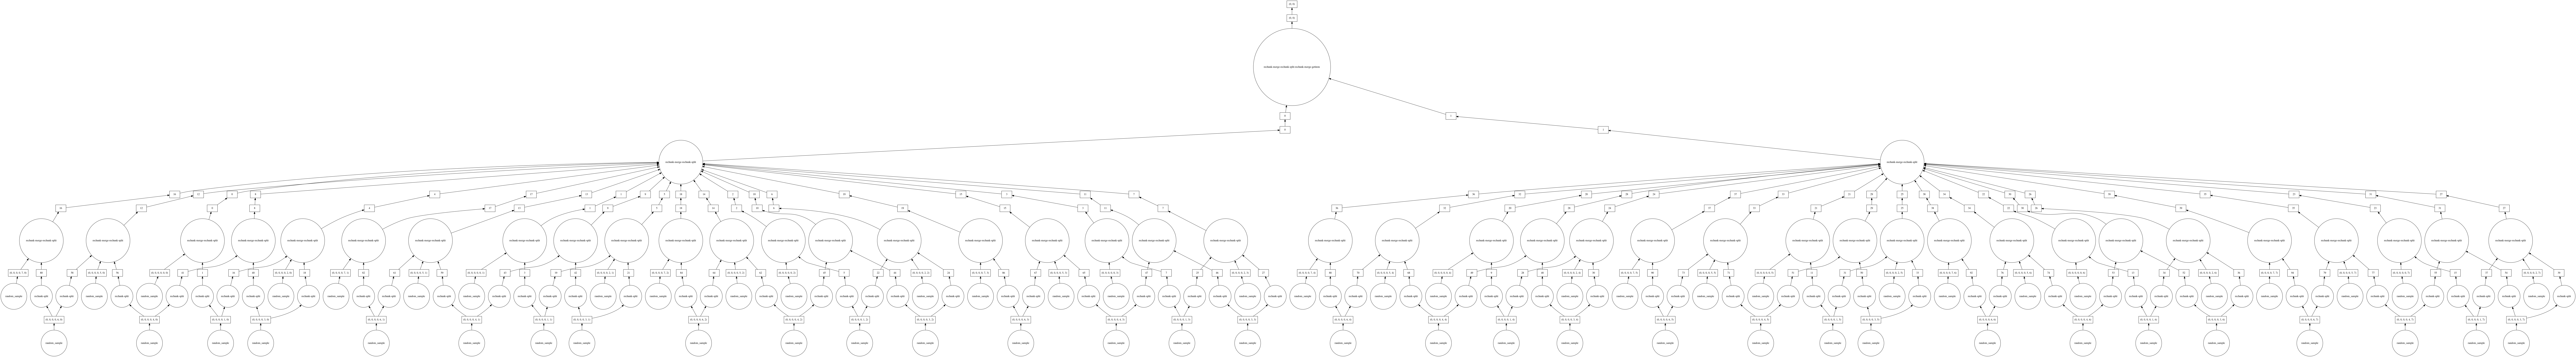

In [5]:
opt_plane.visualize()

In [6]:
%timeit not_opt_plane.compute()

1.79 s ± 27.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit opt_plane.compute()

1.68 s ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Just Optimize

In [8]:
img = random((6, 100, 4, 75, 200, 200))
img = optimize(img)[0]
img

,Array,Chunk
Bytes,57.60 GB,75.00 MB
Shape,"(6, 100, 4, 75, 200, 200)","(6, 25, 4, 25, 25, 25)"
Count,768 Tasks,768 Chunks
Type,float64,numpy.ndarray


In [9]:
not_opt_plane = img[0, 0, 0, 0, :]
not_opt_plane

dask.array<getitem, shape=(200, 200), dtype=float64, chunksize=(25, 25), chunktype=numpy.ndarray>

In [10]:
opt_plane = optimize(img[0, 0, 0, 0, :])[0]
opt_plane

dask.array<getitem, shape=(200, 200), dtype=float64, chunksize=(25, 25), chunktype=numpy.ndarray>

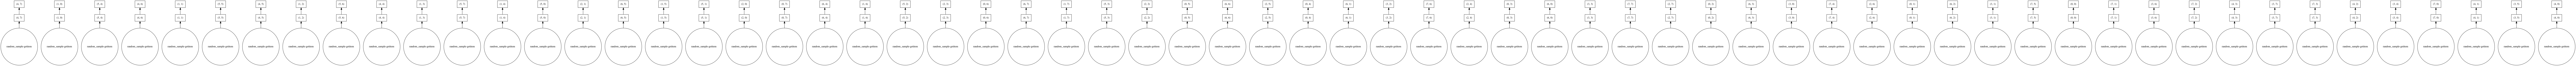

In [11]:
opt_plane.visualize()

In [12]:
%timeit not_opt_plane.compute()

743 ms ± 6.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit opt_plane.compute()

733 ms ± 7.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Just Raw

In [14]:
img = random((6, 100, 4, 75, 200, 200))
img

,Array,Chunk
Bytes,57.60 GB,75.00 MB
Shape,"(6, 100, 4, 75, 200, 200)","(6, 25, 4, 25, 25, 25)"
Count,768 Tasks,768 Chunks
Type,float64,numpy.ndarray


In [15]:
not_opt_plane = img[0, 0, 0, 0, :]
not_opt_plane

dask.array<getitem, shape=(200, 200), dtype=float64, chunksize=(25, 25), chunktype=numpy.ndarray>

In [16]:
opt_plane = optimize(img[0, 0, 0, 0, :])[0]
opt_plane

dask.array<getitem, shape=(200, 200), dtype=float64, chunksize=(25, 25), chunktype=numpy.ndarray>

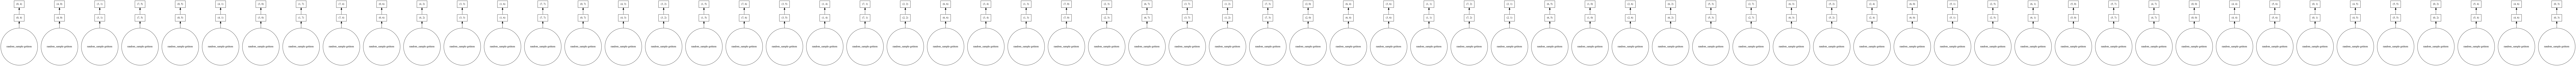

In [17]:
opt_plane.visualize()

In [18]:
%timeit not_opt_plane.compute()

743 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit opt_plane.compute()

745 ms ± 9.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
